# Probabilistic forecasting: prediction intervals and prediction distribution

When trying to anticipate future values, most forecasting models try to predict what will be the most likely value. This is called point-forecasting. Although knowing in advance the expected value of a time series is useful in almost every business case, this kind of prediction does not provide any information about the confidence of the model nor the prediction uncertainty.

Probabilistic forecasting, as opposed to point-forecasting, is a family of techniques that allow for predicting the expected distribution of the outcome instead of a single future value. This type of forecasting provides much rich information since it allows for creating prediction intervals, the range of likely values where the true value may fall. More formally, a prediction interval defines the interval within which the true value of the response variable is expected to be found with a given probability.

There are [multiple ways to estimate prediction intervals](https://otexts.com/fpp3/prediction-intervals.html), most of which require that the residuals (errors) of the model follow a normal distribution. When this property cannot be assumed, two alternatives commonly used are bootstrapping and quantile regression. To illustrate how [skforecast](https://skforecast.org/) allows estimating prediction intervals for multi-step forecasting, the following examples are shown:

+ Prediction intervals based on bootstrapped residuals and [recursive-multi-step forecaster](https://skforecast.org/latest/user_guides/autoregresive-forecaster.html).

+ Prediction intervals based on quantile regression and [direct-multi-step forecaster](https://skforecast.org/latest/user_guides/direct-multi-step-forecasting.html).

All forecasters in skforecast have four different methods that allow for probabilistic forecasting:

+ `predict_bootstrapping`: this method generates multiple forecasting predictions through a bootstrapping process. By sampling from a collection of past observed errors (the residuals), each bootstrapping iteration generates a different set of predictions. The output is a `pandas DataFrame` with one row for each predicted step and one column for each bootstrapping iteration.

+ `predict_intervals`: this method estimates quantile prediction intervals using the values generated with `predict_bootstrapping`.

+ `predict_quantiles`: this method estimates a list of quantile predictions using the values generated with `predict_bootstrapping`.

+ `predict_dist`: this method fits a parametric distribution using the values generated with `predict_bootstrapping`. Any of the continuous distributions available in [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) can be used.

The four can use in-sample residuals (default) or out-sample residuals. In both cases, the residuals can be conditioned on the predicted value to try to account for the existence of a correlation between the predicted values and the residuals.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

As Rob J Hyndman explains in his <a href="https://robjhyndman.com/hyndsight/narrow-pi/">blog</a>, in real-world problems, almost all prediction intervals are too narrow. For example, nominal 95% intervals may only provide coverage between 71% and 87%. This is a well-known phenomenon and arises because they do not account for all sources of uncertainty. With forecasting models, there are at least four sources of uncertainty:

<ul>
  <li>The random error term</li>
    
  <li>The parameter estimates</li>
    
  <li>The choice of model for the historical data</li>
    
  <li>The continuation of the historical data generating process into the future</li>
</ul>

When producing prediction intervals for time series models, generally only the first of these sources is taken into account. Therefore, it is advisable to use test data to validate the empirical coverage of the interval and not solely rely on the expected coverage.

</div>

<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00b8d4;"></i>
    <b style="color: #00b8d4;">&#9998 Note</b>
</p>

Conformal prediction is a relatively new framework that allows for the creation of confidence measures for predictions made by machine learning models. This method is on the roadmap of skforecast, but not yet available.

</div>

## Prediction intervals using bootstrapped residuals

The error of a one-step-ahead forecast is defined as the difference between the actual value and the predicted value ($e_t = y_t - \hat{y}_{t|t-1}$). By assuming that future errors will be similar to past errors, it is possible to simulate different predictions by taking samples from the collection of errors previously seen in the past (i.e., the residuals) and adding them to the predictions.

<p style="text-align: center">
<img src="../img/diagram-bootstrapping-prediction-intervals.png" style="width: 700px;">
<br>
<font size="2.5"> <i>Diagram bootstrapping prediction process.</i></font>
</p>

Repeatedly performing this process creates a collection of slightly different predictions, which represent the distribution of possible outcomes due to the expected variance in the forecasting process.

<p style="text-align: center">
<img src="../img/diagram-bootstrapping-prediction-intervals-2.png" style="width: 550px;">
<br>
<font size="2.5"> <i>Bootstrapping predictions.</i></font>
</p>

Using the outcome of the bootstrapping process, prediction intervals can be computed by calculating the $α/2$ and $1 − α/2$ percentiles at each forecasting horizon. 

<p style="text-align: center">
<img src="../img/forecasting-intervals.gif" style="width: 800px;">
</p>

Alternatively, it is also possible to fit a parametric distribution for each forecast horizon. 

One of the main advantages of this strategy is that it requires only a single model to estimate any interval. However, performing hundreds or thousands of bootstrapping iterations can be computationally expensive and may not always be feasible.

### Libraries

In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from skforecast.plot import plot_residuals
from skforecast.plot import plot_prediction_distribution
from pprint import pprint
plt.style.use('seaborn-v0_8-darkgrid')

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_pinball_loss
from scipy.stats import norm

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

### Data

In [2]:
# Data download
# ==============================================================================
data = fetch_dataset(name='bike_sharing_extended_features')
data.head(2)

bike_sharing_extended_features
------------------------------
Hourly usage of the bike share system in the city of Washington D.C. during the
years 2011 and 2012. In addition to the number of users per hour, the dataset
was enriched by introducing supplementary features. Addition includes calendar-
based variables (day of the week, hour of the day, month, etc.), indicators for
sunlight, incorporation of rolling temperature averages, and the creation of
polynomial features generated from variable pairs. All cyclic variables are
encoded using sine and cosine functions to ensure accurate representation.
Fanaee-T,Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository.
https://doi.org/10.24432/C5W894.
Shape of the dataset: (17352, 90)


,users,weather,month_sin,month_cos,week_of_year_sin,week_of_year_cos,week_day_sin,week_day_cos,hour_day_sin,hour_day_cos,...,temp_roll_mean_1_day,temp_roll_mean_7_day,temp_roll_max_1_day,temp_roll_min_1_day,temp_roll_max_7_day,temp_roll_min_7_day,holiday_previous_day,holiday_next_day,temp,holiday
date_time,,,,,,,,,,,,,,,,,,,,,
2011-01-08 00:00:00,25.0,mist,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.258819,0.965926,...,8.063334,10.127976,9.02,6.56,18.86,4.92,0.0,0.0,7.38,0.0
2011-01-08 01:00:00,16.0,mist,0.5,0.866025,0.120537,0.992709,-0.781832,0.62349,0.500000,0.866025,...,8.029166,10.113334,9.02,6.56,18.86,4.92,0.0,0.0,7.38,0.0


In [3]:
# One hot encoding of categorical variables
# ==============================================================================
encoder = ColumnTransformer(
              [('one_hot_encoder', OneHotEncoder(sparse_output=False), ['weather'])],
              remainder='passthrough',
              verbose_feature_names_out=False
          ).set_output(transform="pandas")
data = encoder.fit_transform(data)

In [4]:
# Select exogenous variables to be included in the model
# ==============================================================================
exog_features = [
    'weather_clear', 'weather_mist', 'weather_rain', 'month_sin', 'month_cos',
    'week_of_year_sin', 'week_of_year_cos', 'week_day_sin', 'week_day_cos',
    'hour_day_sin', 'hour_day_cos', 'sunrise_hour_sin', 'sunrise_hour_cos',
    'sunset_hour_sin', 'sunset_hour_cos', 'temp', 'holiday'
]
data = data[['users'] + exog_features]

In [5]:
# Split train-validation-test
# ==============================================================================
data = data.loc['2011-05-30 23:59:00':, :]
end_train = '2012-08-30 23:59:00'
end_validation = '2012-11-15 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-05-31 00:00:00 --- 2012-08-30 23:00:00  (n=10992)
Dates validacion : 2012-08-31 00:00:00 --- 2012-11-15 23:00:00  (n=1848)
Dates test       : 2012-11-16 00:00:00 --- 2012-12-30 23:00:00  (n=1080)


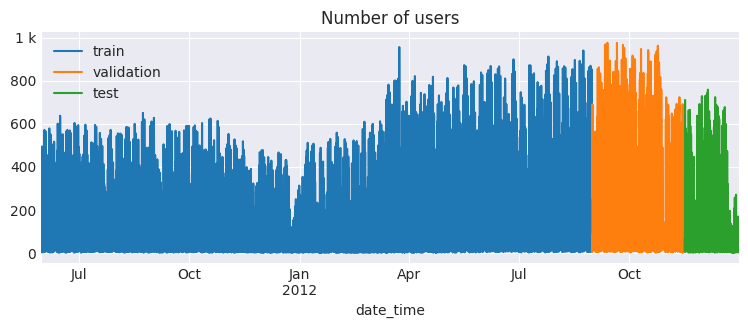

In [6]:
# Plot time series partition
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 3))
data_train['users'].plot(label='train', ax=ax)
data_val['users'].plot(label='validation', ax=ax)
data_test['users'].plot(label='test', ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title('Number of users')
ax.legend();

### In sample residuals

By default, intervals are calculated using in-sample residuals (residuals from the training set). However, this can result in intervals that are too narrow (overly optimistic).

The `backtesting_forecaster()` function is used to generate the prediction intervals for the entire test set. 

+ The `interval` argument indicates the desired coverage probability of the prediction intervals. In this case, `interval` is set to `[10, 90]`, which means that the prediction intervals are calculated for the 10th and 90th percentiles, resulting in a theoretical coverage probability of 80%. 

+ The `n_boot` argument is used to specify the number of bootstrap samples to be used in estimating the prediction intervals. The larger the number of samples, the more accurate the prediction intervals will be, but the longer the calculation will take.

In [7]:
# Create forecaster
# ==============================================================================
params = {
    "n_estimators": 600,
    "max_depth": 6,
    "min_data_in_leaf": 88,
    "learning_rate": 0.2520098236227423,
    "feature_fraction": 0.6,
    "max_bin": 75,
    "reg_alpha": 1.0,
    "reg_lambda": 0.8,
}
lags = 48

forecaster = ForecasterAutoreg(
    regressor     = LGBMRegressor(random_state=15926, verbose=-1, **params),
    lags          = lags,
    binner_kwargs = {"n_bins": 10},
)

In [8]:
# Backtesting with prediction intervals in test data using in-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['users'],
                          exog                = data[exog_features],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90], # 80% prediction interval
                          n_boot              = 250,
                          in_sample_residuals = True, # Use in-sample residuals
                          binned_residuals    = False,
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )

predictions.head(5)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,70.009970,54.072928,82.715810
2012-11-16 01:00:00,45.679914,24.743146,61.287412
2012-11-16 02:00:00,19.225220,2.149938,38.884099
2012-11-16 03:00:00,-0.039409,-13.141700,15.812282
2012-11-16 04:00:00,0.154831,-12.666161,11.679665


In [9]:
# Function to plot predicted intervals and calculate coverage of a given interval
# ======================================================================================

def plot_predicted_intervals(
    predictions: pd.DataFrame,
    y_true: pd.DataFrame,
    target_variable: str,
    initial_x_zoom: list=None,
    title: str=None,
    xaxis_title: str=None,
    yaxis_title: str=None,
    ax: plt.Axes=None
):
    """
    Plot predicted intervals vs real values

    Parameters
    ----------
    predictions : pandas DataFrame
        Predicted values and intervals.
    y_true : pandas DataFrame
        Real values of target variable.
    target_variable : str
        Name of target variable.
    initial_x_zoom : list, default `None`
        Initial zoom of x-axis, by default None.
    title : str, default `None`
        Title of the plot, by default None.
    xaxis_title : str, default `None`
        Title of x-axis, by default None.
    yaxis_title : str, default `None`
        Title of y-axis, by default None.
    ax : matplotlib axes, default `None`
        Axes where to plot, by default None.
    
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 3))

    y_true.loc[predictions.index, target_variable].plot(ax=ax, label='Real value')
    predictions['pred'].plot(ax=ax, label='prediction')
    ax.fill_between(
        predictions.index,
        predictions['lower_bound'],
        predictions['upper_bound'],
        color = '#444444',
        alpha = 0.3,
    )
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_ylabel(yaxis_title)
    ax.set_xlabel(xaxis_title)
    ax.set_title(title)
    ax.legend()

    if initial_x_zoom is not None:
        ax.set_xlim(initial_x_zoom)


def empirical_coverage(y, lower_bound, upper_bound):
    """
    Calculate coverage of a given interval
    """
    return np.mean(np.logical_and(y >= lower_bound, y <= upper_bound))

Predicted interval coverage: 63.24 %
Area of the interval: 91235.15


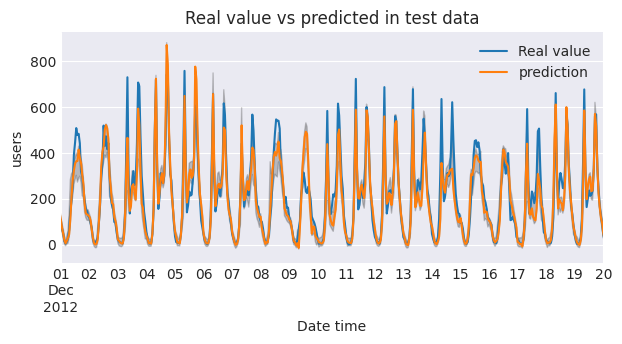

In [10]:
# Plot intervals
# ==============================================================================
plot_predicted_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "users",
    initial_x_zoom  = ['2012-12-01', '2012-12-20'],
    title           = "Real value vs predicted in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "users",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = empirical_coverage(
    y = data.loc[end_validation:, 'users'],
    lower_bound = predictions["lower_bound"], 
    upper_bound = predictions["upper_bound"]
)
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

The prediction intervals exhibit overconfidence as they tend to be excessively narrow, resulting in a true coverage that falls below the nominal coverage. This phenomenon arises from the tendency of in-sample residuals to often overestimate the predictive capacity of the model.

### Out sample residuals (non-conditioned on predicted values)

The `set_out_sample_residuals()` method is used to specify out-sample residuals computed with a validation set through backtesting.  Once the new residuals have been added to the forecaster, set `in_sample_residuals` to `False` use them.

In [11]:
# Backtesting on validation data to obtain out-sample residuals
# ==============================================================================
_, predictions_val = backtesting_forecaster(
                         forecaster         = forecaster,
                         y                  = data.loc[:end_validation, 'users'],
                         exog               = data.loc[:end_validation, exog_features],
                         steps              = 24,
                         metric             = 'mean_absolute_error',
                         initial_train_size = len(data.loc[:end_train]),
                         refit              = False,
                         n_jobs             = 'auto',
                         verbose            = False,
                         show_progress      = True
                     )

residuals = data.loc[predictions_val.index, 'users'] - predictions_val['pred']
residuals = residuals.dropna()

  0%|          | 0/77 [00:00<?, ?it/s]

positive    1118
negative     730
Name: count, dtype: int64


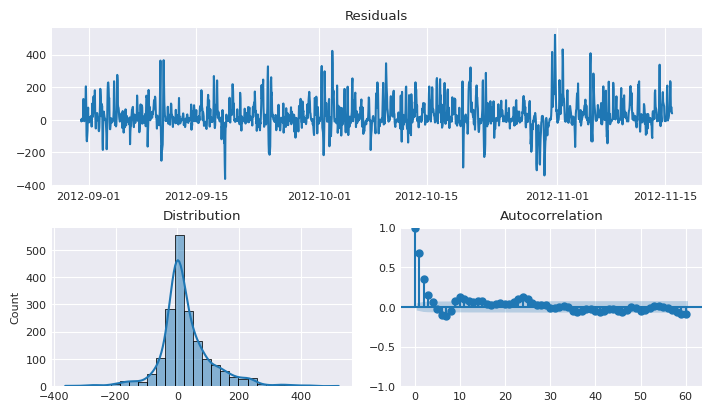

In [12]:
# Out-sample residuals distribution
# ==============================================================================
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))

In [13]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(residuals=residuals)

In [14]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['users'],
                          exog                = data[exog_features],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90], # 80% prediction interval
                          n_boot              = 250,
                          in_sample_residuals = False, # Use out-sample residuals
                          binned_residuals    = False,
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                      )
predictions.head(5)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,70.009970,35.232983,195.389471
2012-11-16 01:00:00,45.679914,-9.233033,209.921993
2012-11-16 02:00:00,19.225220,-8.006518,202.804502
2012-11-16 03:00:00,-0.039409,-17.532126,235.975562
2012-11-16 04:00:00,0.154831,-30.978673,228.508684


Predicted interval coverage: 75.46 %
Area of the interval: 316412.72


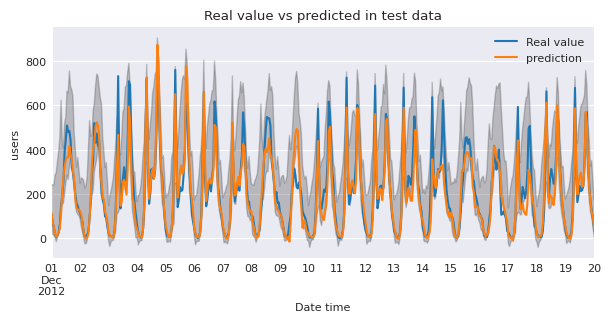

In [15]:
# Plot intervals
# ==============================================================================
plot_predicted_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "users",
    initial_x_zoom  = ['2012-12-01', '2012-12-20'],
    title           = "Real value vs predicted in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "users",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = empirical_coverage(
    y = data.loc[end_validation:, 'users'],
    lower_bound = predictions["lower_bound"], 
    upper_bound = predictions["upper_bound"]
)
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

The resulting prediction intervals derived from the out-of-sample residuals are wider than those generated using the in-sample residuals. This results in an empirical coverage that is closer to the nominal coverage, although still lower. Examining the plot, it is easy to see that the intervals are particularly wide when the predicted values are low, indicating that the model is not able to properly locate the uncertainty of its predictions.

### Out sample residuals (conditioned on predicted values)

The bootstrapping process assumes that the residuals are independently distributed so that they can be used independently of the predicted value. In reality, this is rarely true; in most cases, the magnitude of the residuals is correlated with the magnitude of the predicted value. In this case, for example, one would hardly expect the error to be the same when the predicted number of users is close to zero as when it is in the hundreds.

To account for the dependence between the residuals and the predicted values, skforecast allows to **partition the residuals into *K* bins**, where each bin is associated with a range of predicted values. Using this strategy, the bootstrapping process samples the residuals from different bins depending on the predicted value, which can improve the coverage of the interval while adjusting the width if necessary, allowing the model to **better distribute the uncertainty of its predictions**.

To enable the forecaster to bin the out-sample residuals, the predicted values are passed to the `set_out_sample_residuals()` method in addition to the residuals. Internally, skforecast uses a `sklearn.preprocessing.KBinsDiscretizer` with the parameters: `n_bins=15`, `encode=ordinal`, `strategy=quantile`,
`subsample=10000`, `random_state=789654`, `dtype=np.float64`. The binning process can be adjusted using the argument `binner_kwargs` of the Forecaster object.

In [16]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = LGBMRegressor(random_state=15926, verbose=-1, **params),
                 lags          = lags,
                 binner_kwargs = {'n_bins': 10}   
             )

forecaster.fit(
    y     = data.loc[:end_validation, 'users'],
    exog  = data.loc[:end_validation, exog_features]
)

During the training process, the forecaster uses the in-sample predictions to define the intervals at which the residuals are stored, depending on the predicted value to which they are related. Although not used in this example, the in-sample residuals are divided into bins and stored in the `in_sample_residuals_by_bin` attribute.

In [17]:
# Intervals of the residual bins
# ==============================================================================
pprint(forecaster.binner_intervals)

{0: (-8.229467171553717, 11.116037535200665),
 1: (11.116037535200665, 31.879155847370434),
 2: (31.879155847370434, 75.9019071402224),
 3: (75.9019071402224, 124.5691653220086),
 4: (124.5691653220086, 170.35484312260417),
 5: (170.35484312260417, 218.96823239624555),
 6: (218.96823239624555, 278.6496576655771),
 7: (278.6496576655771, 355.13229168292287),
 8: (355.13229168292287, 486.1660497574729),
 9: (486.1660497574729, 970.517259284916)}


Next, the out-of-sample residuals are stored in the predictor. Since the predicted values are also provided, they are binned according to the intervals learned during the fit. To avoid using too much memory, a maximum of 200 residuals are stored per bin.

In [18]:
# Store out-sample residuals in the forecaster
# ==============================================================================
forecaster.set_out_sample_residuals(residuals=residuals, y_pred=predictions_val['pred'])

In [19]:
# Number of residuals by bin
# ==============================================================================
for k, v in forecaster.out_sample_residuals_by_bin.items():
    print(f" Bin {k}: n={len(v)}")

 Bin 0: n=114
 Bin 1: n=190
 Bin 2: n=183
 Bin 3: n=162
 Bin 4: n=126
 Bin 5: n=164
 Bin 6: n=175
 Bin 7: n=200
 Bin 8: n=200
 Bin 9: n=200


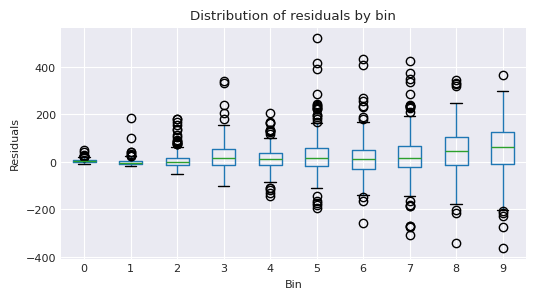

In [20]:
# Distribution of the residual by bin
# ==============================================================================
out_sample_residuals_by_bin_df = pd.DataFrame(
    dict([(k, pd.Series(v)) for k,v in forecaster.out_sample_residuals_by_bin.items()])
)
fig, ax = plt.subplots(figsize=(6, 3))
out_sample_residuals_by_bin_df.boxplot(ax=ax)
ax.set_title("Distribution of residuals by bin")
ax.set_xlabel("Bin")
ax.set_ylabel("Residuals");

The box plots show how the spread and magnitude of the residuals differ depending on the predicted value. For example, for bin 0, whose predicted value is in the interval (-8.2, 11.1), the residuals never exceed an absolute value of 100, while for bin 9, for predicted values in the interval (486.2, 970.5), they often do.

Finally, the prediction intervals for the test data are estimated using the backtesting process, with out-of-sample residuals conditioned on the predicted values.

In [21]:
# Backtesting with prediction intervals in test data using out-sample residuals
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster          = forecaster,
                          y                   = data['users'],
                          exog                = data[exog_features],
                          steps               = 24,
                          metric              = 'mean_absolute_error',
                          initial_train_size  = len(data.loc[:end_validation]),
                          refit               = False,
                          interval            = [10, 90], # 80% prediction interval
                          n_boot              = 250,
                          in_sample_residuals = False, # Use out-sample residuals
                          binned_residuals    = True,  # Use binned residuals
                          n_jobs              = 'auto',
                          verbose             = False,
                          show_progress       = True
                     )
predictions.head(3)

  0%|          | 0/45 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,70.009970,43.169483,111.284002
2012-11-16 01:00:00,45.679914,16.252003,124.574522
2012-11-16 02:00:00,19.225220,5.881439,67.542903


Predicted interval coverage: 84.44 %
Area of the interval: 284549.02


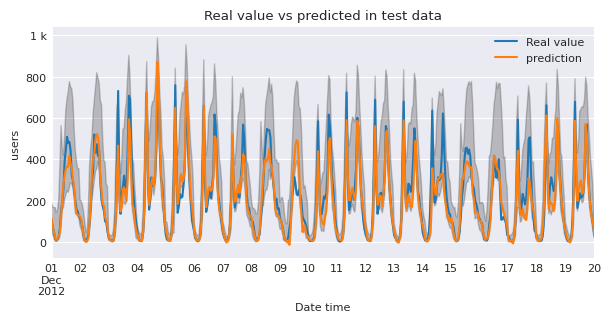

In [22]:
# Plot intervals
# ==============================================================================
plot_predicted_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "users",
    initial_x_zoom  = ['2012-12-01', '2012-12-20'],
    title           = "Real value vs predicted in test data",
    xaxis_title     = "Date time",
    yaxis_title     = "users",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = empirical_coverage(
    y = data.loc[end_validation:, 'users'],
    lower_bound = predictions["lower_bound"], 
    upper_bound = predictions["upper_bound"]
)
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions["upper_bound"] - predictions["lower_bound"]).sum()
print(f"Area of the interval: {round(area, 2)}")

When using out-of-sample residuals conditioned on the predicted value, the area of the interval is significantly reduced and the uncertainty is mainly allocated to the predictions with high values. The empirical coverage is slightly above the expected coverage, which means that the estimated intervals are conservative.

### Predict bootstraping, quantile and distribution

The previous sections have demonstrated the use of the backtesting process to estimate the prediction interval over a given period of time. The goal is to mimic the behavior of the model in production by running predictions at regular intervals, incrementally updating the input data.

Alternatively, it is possible to run a single prediction that forecasts *N* steps ahead without going through the entire backtesting process. In such cases, skforecast provides four different methods: `predict_bootstrapping`, `predict_interval`, `predict_quantile` and `predict_distribution`.

**Predict Bootstraping** 

The `predict_bootstrapping` method performs the `n_boot` bootstrapping iterations that generate the alternative prediction paths. These are the underlying values used to compute the intervals, quantiles, and distributions.

In [23]:
# Fit forecaster
# ==============================================================================
forecaster.fit(
    y     = data.loc[:end_validation, 'users'],
    exog  = data.loc[:end_validation, exog_features]
)

In [24]:
# Predict 10 different forecasting sequences of 7 steps each using bootstrapping
# ==============================================================================
boot_predictions = forecaster.predict_bootstrapping(
                       exog   = data_test[exog_features],
                       steps  = 7,
                       n_boot = 25
                   )
boot_predictions

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9,...,pred_boot_15,pred_boot_16,pred_boot_17,pred_boot_18,pred_boot_19,pred_boot_20,pred_boot_21,pred_boot_22,pred_boot_23,pred_boot_24
2012-11-16 00:00:00,45.093002,72.342580,66.104241,61.857376,70.287466,62.609630,66.876032,-7.240933,62.627233,77.650055,...,76.247357,73.723864,67.528771,84.523891,57.991403,57.230669,53.758879,50.970186,61.188773,65.951935
2012-11-16 01:00:00,30.032415,38.021197,49.615419,40.748506,67.174037,36.002591,54.361503,21.593390,55.480739,58.462454,...,59.511614,63.352858,10.788131,51.220874,55.867923,26.405396,11.751619,5.177635,31.348893,42.467320
2012-11-16 02:00:00,30.545283,26.680513,6.443589,14.794040,33.030783,17.851320,36.576223,7.061209,9.311169,33.137676,...,13.015551,3.393468,-4.892471,-18.772457,44.950823,-3.993792,10.331932,13.198095,7.248641,25.146473
2012-11-16 03:00:00,-11.162445,-10.752284,-31.982261,-10.154747,12.638911,1.316467,12.070534,-10.006870,-6.225798,0.577154,...,-0.645263,-13.056397,-15.563677,3.780053,19.434325,0.259401,-7.441530,3.329159,-13.072710,-11.449338
2012-11-16 04:00:00,29.501855,0.390785,-8.150613,6.811819,5.470563,0.720501,-20.672444,2.594434,-9.086244,18.142421,...,-1.323837,12.015726,-1.160147,-0.003795,-18.597541,3.943013,-4.988980,-11.808740,-1.713594,-8.759476
2012-11-16 05:00:00,50.925760,25.303883,57.989387,43.231353,29.429184,37.448429,28.302156,54.538115,48.028895,52.058786,...,39.547522,44.653644,35.625141,45.105871,53.008536,54.793102,55.503852,51.275060,29.051023,35.964536
2012-11-16 06:00:00,105.678239,83.386178,135.604603,145.784610,55.191766,142.521798,57.708828,141.336677,129.600609,90.586368,...,113.890538,134.525734,148.178852,127.608854,62.810049,121.878572,129.100314,147.873421,107.950283,89.421032


A ridge plot is a useful way to visualize the uncertainty of a forecasting model. This plot estimates a kernel density for each step by using the bootstrapped predictions.

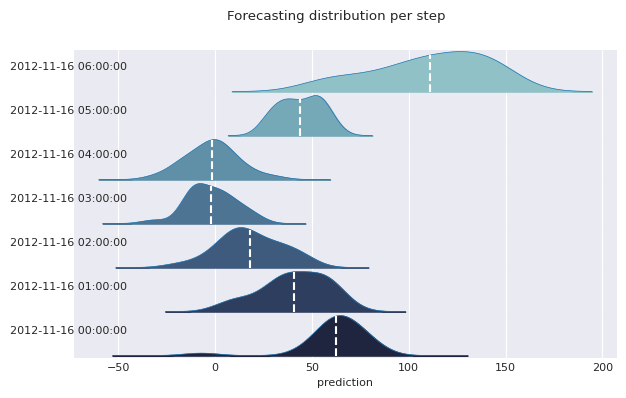

In [25]:
# Ridge plot of bootstrapping predictions
# ==============================================================================
_ = plot_prediction_distribution(boot_predictions, figsize=(7, 4))

**Predict Interval**

In most cases, the user is interested in a specific interval rather than the entire bootstrapping simulation matrix. To address this need, skforecast provides the `predict_interval` method. This method internally uses `predict_bootstrapping` to obtain the bootstrapping matrix and estimates the upper and lower quantiles for each step, thus providing the user with the desired prediction intervals.

In [26]:
# Predict intervals for next 7 steps, quantiles 10th and 90th
# ==============================================================================
predictions = forecaster.predict_interval(
                  exog     = data_test[exog_features],
                  steps    = 7,
                  interval = [10, 90],
                  n_boot   = 150
              )
predictions

,pred,lower_bound,upper_bound
2012-11-16 00:00:00,70.009970,54.072928,82.751111
2012-11-16 01:00:00,45.679914,26.786421,59.815055
2012-11-16 02:00:00,19.225220,1.898509,38.591876
2012-11-16 03:00:00,-0.039409,-13.577625,15.542587
2012-11-16 04:00:00,0.154831,-13.147107,8.408095
2012-11-16 05:00:00,37.330998,24.934087,56.351798
2012-11-16 06:00:00,116.737843,68.126489,142.437896


**Predict Quantile**

This method operates identically to `predict_interval`, with the added feature of enabling users to define a specific list of quantiles for estimation at each step. It's important to remember that these quantiles should be specified within the range of 0 to 1.

In [27]:
# Predict quantiles for next 7 steps, quantiles 5th, 25th, 75th and 95th
# ==============================================================================
predictions = forecaster.predict_quantiles(
                  exog      = data_test[exog_features],
                  steps     = 7,
                  n_boot    = 150,
                  quantiles = [0.05, 0.25, 0.75, 0.95],
              )
predictions

,q_0.05,q_0.25,q_0.75,q_0.95
2012-11-16 00:00:00,50.927848,62.087299,74.199091,87.257236
2012-11-16 01:00:00,21.554404,37.340117,53.545533,64.323208
2012-11-16 02:00:00,-4.240677,10.073961,27.081542,44.854803
2012-11-16 03:00:00,-16.093260,-7.342569,8.959304,20.346569
2012-11-16 04:00:00,-20.497782,-8.361238,4.574280,15.235284
2012-11-16 05:00:00,20.353950,31.219222,48.302874,62.468249
2012-11-16 06:00:00,55.085643,90.848249,127.747950,146.933456


**Predict Distribution**

The intervals estimated so far are distribution-free, which means that no assumptions are made about a particular distribution. The `predict_dist` method in skforecast allows fitting a parametric distribution to the bootstrapped prediction samples obtained with `predict_bootstrapping`. This is useful when there is reason to believe that the forecast errors follow a particular distribution, such as the normal distribution or the student's t-distribution. The `predict_dist` method allows the user to specify any continuous distribution from the [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions) module.

In [28]:
# Predict the parameters of a normal distribution for the next 7 steps
# ==============================================================================
predictions = forecaster.predict_dist(
                  exog         = data_test[exog_features],
                  steps        = 7,
                  n_boot       = 150,
                  distribution = norm
              )
predictions

,loc,scale
2012-11-16 00:00:00,68.012597,14.302118
2012-11-16 01:00:00,44.996603,13.993448
2012-11-16 02:00:00,19.073899,14.534767
2012-11-16 03:00:00,0.565316,13.557214
2012-11-16 04:00:00,-1.762005,10.605301
2012-11-16 05:00:00,39.570946,14.448296
2012-11-16 06:00:00,106.968456,27.969678


## Prediction intervals using quantile regression models


As opposed to linear regression, which is intended to estimate the conditional mean of the response variable given certain values of the predictor variables, quantile regression aims at estimating the conditional quantiles of the response variable. For a continuous distribution function, the $\alpha$-quantile $Q_{\alpha}(x)$ is defined such that the probability of $Y$ being smaller than $Q_{\alpha}(x)$ is, for a given $X=x$, equal to $\alpha$. For example, 36% of the population values are lower than the quantile  $Q=0.36$. The most known quantile is the 50%-quantile, more commonly called the median.

By combining the predictions of two quantile regressors, it is possible to build an interval. Each model estimates one of the limits of the interval. For example, the models obtained for $Q = 0.1$ and $Q = 0.9$ produce an 80% prediction interval (90% - 10% = 80%).

Several machine learning algorithms are capable of modeling quantiles. Some of them are:

+ [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html)

+ [XGBoost](https://xgboost.readthedocs.io/en/stable/python/index.html)

+ [CatBoost](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor)

+ [Scikit-learn HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)

+ [Scikit-learn QuantileRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.QuantileRegressor.html#sklearn.linear_model.QuantileRegressor)

+ [skranger quantile RandomForest](https://skranger.readthedocs.io/en/stable/index.html)


Just as the squared-error loss function is used to train models that predict the mean value, a specific loss function is needed in order to train models that predict quantiles. The most common metric used for quantile regression is calles [quantile loss  or pinball loss](https://en.wikipedia.org/wiki/Quantile_regression):


$$\text{pinball}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1}  \alpha \max(y_i - \hat{y}_i, 0) + (1 - \alpha) \max(\hat{y}_i - y_i, 0)$$

where $\alpha$ is the target quantile, $y$ the real value and $\hat{y}$ the quantile prediction.

It can be seen that loss differs depending on the evaluated quantile. The higher the quantile, the more the loss function penalizes underestimates, and the less it penalizes overestimates. As with MSE and MAE, the goal is to minimize its values (the lower loss, the better).

Two disadvantages of quantile regression, compared to the bootstrap approach to prediction intervals, are that each quantile needs its regressor and quantile regression is not available for all types of regression models. However, once the models are trained, the inference is much faster since no iterative process is needed.

This type of prediction intervals can be easily estimated using [ForecasterAutoregDirect](https://joaquinamatrodrigo.github.io/skforecast/latest/api/ForecasterAutoregDirect.html) and [ForecasterAutoregMultiVariate](https://joaquinamatrodrigo.github.io/skforecast/latest/api/ForecasterMultiVariate.html) models.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

Forecasters of type <code>ForecasterAutoregDirect</code> are slower than <code>ForecasterAutoregRecursive</code> because they require training one model per step. Although they can achieve better performance, their scalability is an important limitation when many steps need to be predicted. To limit the time required to run the following examples, the data is aggregated from hourly frequency to daily frequency and only 7 steps ahead (one week) are predicted.

</div>

### Data

In [29]:
# Data download
# ==============================================================================
data = fetch_dataset(name='vic_electricity')

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 4)


In [30]:
# Data preparation (aggregation at daily level)
# ==============================================================================
data = data.resample(rule="D", closed="left", label="right").agg(
    {"Demand": "sum", "Temperature": "mean", "Holiday": "max"}
)
data.head(3)

,Demand,Temperature,Holiday
Time,,,
2012-01-01,82531.745918,21.047727,True
2012-01-02,227778.257304,26.578125,True
2012-01-03,275490.988882,31.751042,True


In [31]:
# Split data into train-validation-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-9-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(
    f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}"
    f"  (n={len(data_train)})"
)
print(
    f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}"
    f"  (n={len(data_val)})"
)
print(
    f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}"
    f"  (n={len(data_test)})"
)

Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00  (n=731)
Validation dates : 2014-01-01 00:00:00 --- 2014-09-30 00:00:00  (n=273)
Test dates       : 2014-10-01 00:00:00 --- 2014-12-30 00:00:00  (n=91)


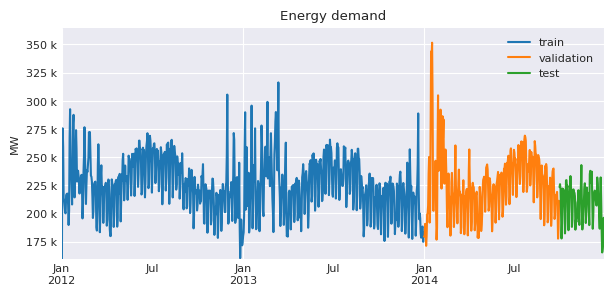

In [38]:
# Plot time series partition
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train['Demand'].plot(label='train', ax=ax)
data_val['Demand'].plot(label='validation', ax=ax)
data_test['Demand'].plot(label='test', ax=ax)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylim(bottom=160_000)
ax.set_ylabel('MW')
ax.set_xlabel('')
ax.set_title('Energy demand')
ax.legend();

### Quantile regresion models

An 80% prediction interval is estimated for 7 steps-ahead predictions using quantile regression. A LightGBM gradient boosting model is trained in this example, however, the reader may use any other model just replacing the definition of the regressor.

In [33]:
# Create forecasters: one for each bound of the interval
# ==============================================================================
# The forecasters obtained for alpha=0.1 and alpha=0.9 produce a 80% confidence
# interval (90% - 10% = 80%).

# Forecaster for quantile 10%
forecaster_q10 = ForecasterAutoregDirect(
                     regressor = LGBMRegressor(
                                     objective     = 'quantile',
                                     metric        = 'quantile',
                                     alpha         = 0.1,
                                     learning_rate = 0.01,
                                     max_depth     = 3,
                                     n_estimators  = 500,
                                     verbose       = -1
                                 ),
                     lags = 7,
                     steps = 7
                 )
                  
# Forecaster for quantile 90%
forecaster_q90 = ForecasterAutoregDirect(
                     regressor = LGBMRegressor(
                                     objective     = 'quantile',
                                     metric        = 'quantile',
                                     alpha         = 0.9,
                                     learning_rate = 0.1,
                                     max_depth     = 3,
                                     n_estimators  = 100,
                                     verbose       = -1
                                 ),
                     lags = 7,
                     steps = 7
                 )

forecaster_q10.fit(y=data['Demand'])
forecaster_q90.fit(y=data['Demand'])

When validating a quantile regression model, a custom metric must be provided depending on the quantile being estimated.

In [34]:
# Loss function for each quantile (pinball_loss)
# ==============================================================================
def mean_pinball_loss_q10(y_true, y_pred):
    """
    Pinball loss for quantile 10.
    """
    return mean_pinball_loss(y_true, y_pred, alpha=0.1)


def mean_pinball_loss_q90(y_true, y_pred):
    """
    Pinball loss for quantile 90.
    """
    return mean_pinball_loss(y_true, y_pred, alpha=0.9)

### Predictions (backtesting)

Once the quantile forecasters are trained, they can be used to predict each of the bounds of the forecasting interval.

In [35]:
# Backtesting on test data
# ==============================================================================
metric_q10, predictions_q10 = backtesting_forecaster(
                                  forecaster          = forecaster_q10,
                                  y                   = data['Demand'],
                                  steps               = 7,
                                  metric              = mean_pinball_loss_q10,
                                  initial_train_size  = len(data.loc[:end_validation]),
                                  refit               = False,
                                  n_jobs              = 'auto',
                                  verbose             = False,
                                  show_progress       = True
                              )

metric_q90, predictions_q90 = backtesting_forecaster(
                                  forecaster          = forecaster_q90,
                                  y                   = data['Demand'],
                                  steps               = 7,
                                  metric              = mean_pinball_loss_q90,
                                  initial_train_size  = len(data.loc[:end_validation]),
                                  refit               = False,
                                  n_jobs              = 'auto',
                                  verbose             = False,
                                  show_progress       = True
                              )

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

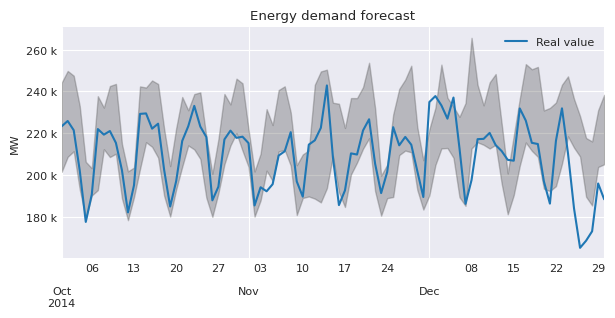

In [36]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data.loc[end_validation:, 'Demand'].plot(ax=ax, label='Real value')
ax.fill_between(
    data.loc[end_validation:].index,
    predictions_q10['pred'],
    predictions_q90['pred'],
    color = '#444444',
        alpha = 0.3,
)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_ylabel('MW')
ax.set_xlabel('')
ax.set_title('Energy demand forecast')
ax.legend();

Predictions generated for each model are used to define the upper and lower limits of the interval.

In [37]:
# Predicted interval coverage (on test data)
# ==============================================================================
coverage = empirical_coverage(
    y = data.loc[end_validation:, 'Demand'],
    lower_bound = predictions_q10["pred"], 
    upper_bound = predictions_q90["pred"]
)
print(f"Predicted interval coverage: {round(100*coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions_q90["pred"] - predictions_q10["pred"]).sum()
print(f"Area of the interval: {round(area, 2)}")

Predicted interval coverage: 74.73 %
Area of the interval: 2832564.24
